In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt

import UCI_loader
import importlib

In [28]:
# network class
class Network(nn.Module):
    def __init__(self, indim):
        super(Network,self).__init__()
        self.l1 = nn.Linear(indim,100)
        self.l2 = nn.Linear(100,50)
        self.l3 = nn.Linear(50,2) 
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = self.l3(x)
        return x

def tiltedLC(x, y, tau, h):
    e= y-x # errors
    ind= (torch.sign(e)+1)/2 # the division in the log-cosh is only about the origin
    quantFactor= (1-tau)*(1-ind) + tau*ind
    loss= quantFactor*torch.log(torch.cosh(e/h))
    loss= torch.mean(loss)*h
    return loss

def check_loss(x, y, tau): # the x,*args way to pass arguments to this function is an idiom for the scipy.optimize() library y = args[0][0]
    e = y-x
    ind = (torch.sign(-e)+1)/2
    loss = torch.mean(e*(tau-ind))
    return loss

class TiltedLC(nn.Module):
    def __init__(self):
        super(TiltedLC, self).__init__()
    def forward(self, x, y, tau, h):
        return tiltedLC(x, y, tau, h)


class CheckLC(nn.Module):
    def __init__(self):
        super(CheckLC, self).__init__()
    def forward(self, x, y, tau):
        return check_loss(x, y, tau)

# Getting the data
importlib.reload(UCI_loader)
data= UCI_loader.UCIDatasets("energy") 
train_data= data.get_split()
test_data= data.get_split(train=False)


# instantiating the network for training on this dataset
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model1= Network(indim=8).to(device=device)
model2= Network(indim=8).to(device=device)
tau= 0.5
h= 0.05

criterion1= TiltedLC()
criterion2= CheckLC()
optimizer1= optim.Adam(model1.parameters())
optimizer2= optim.Adam(model2.parameters())

In [41]:
# the fundamental training loop
 # instantiating the DataLoader
trainloader = torch.utils.data.DataLoader(
                    train_data,
                    batch_size=16,
                    shuffle=True)
ls_a= []
N_EPOCHS= 100
for epoch in range(N_EPOCHS):
    epoch_loss1 = 0.0
    for inputs, labels in trainloader:
        inputs = inputs.to(device) 
        labels = labels.to(device)
        optimizer1.zero_grad() 
        outputs = model1(inputs) 
        loss1= criterion1(outputs, labels, tau, h) 
        loss1.backward() 
        optimizer1.step() 
        epoch_loss1+= loss1.item() 
    ls_a.append((epoch_loss1/len(trainloader)))
    print("Epoch: {} Loss: {}".format(epoch,
           epoch_loss1/len(trainloader)))

Epoch: 0 Loss: 0.025648067991079933
Epoch: 1 Loss: 0.024835818595337598
Epoch: 2 Loss: 0.024986274910836735
Epoch: 3 Loss: 0.023420117520303887
Epoch: 4 Loss: 0.02287495773370293
Epoch: 5 Loss: 0.023071465886790644
Epoch: 6 Loss: 0.02182656905444508
Epoch: 7 Loss: 0.022789362733337013
Epoch: 8 Loss: 0.021053404589606958
Epoch: 9 Loss: 0.020063482500104743
Epoch: 10 Loss: 0.02099388070531528
Epoch: 11 Loss: 0.020206852625547486
Epoch: 12 Loss: 0.02194355335086584
Epoch: 13 Loss: 0.019250839144330133
Epoch: 14 Loss: 0.019445810784501107
Epoch: 15 Loss: 0.01905083016026765
Epoch: 16 Loss: 0.0180636117531156
Epoch: 17 Loss: 0.016623981307599355
Epoch: 18 Loss: 0.016648581018671393
Epoch: 19 Loss: 0.017244176388802854
Epoch: 20 Loss: 0.015814901350743392
Epoch: 21 Loss: 0.0163420796637762
Epoch: 22 Loss: 0.015459822882390157
Epoch: 23 Loss: 0.015472425386013294
Epoch: 24 Loss: 0.0154158682721159
Epoch: 25 Loss: 0.01404703834983097
Epoch: 26 Loss: 0.015142101392319257
Epoch: 27 Loss: 0.01443

In [42]:
ls_b= []
for epoch in range(N_EPOCHS):
    epoch_loss2 = 0.0
    for inputs, labels in trainloader:
        inputs = inputs.to(device) 
        labels = labels.to(device)
        optimizer2.zero_grad() 
        outputs = model2(inputs) 
        loss2= criterion2(outputs, labels, tau)
        loss2.backward() 
        optimizer2.step() 
        epoch_loss2+= loss2.item() 
    ls_b.append(epoch_loss2/len(trainloader))
    print("Epoch: {} Loss: {}".format(epoch,
           epoch_loss2/len(trainloader)))

Epoch: 0 Loss: 0.03977864866398952
Epoch: 1 Loss: 0.03900789507580074
Epoch: 2 Loss: 0.038452257571572605
Epoch: 3 Loss: 0.03906484879553318
Epoch: 4 Loss: 0.034091489389538765
Epoch: 5 Loss: 0.0356759201227264
Epoch: 6 Loss: 0.03378346896815029
Epoch: 7 Loss: 0.03319645588370887
Epoch: 8 Loss: 0.034314056689089
Epoch: 9 Loss: 0.03237829867496409
Epoch: 10 Loss: 0.031394981207664714
Epoch: 11 Loss: 0.03190299015576867
Epoch: 12 Loss: 0.03160361365669153
Epoch: 13 Loss: 0.0325861676088111
Epoch: 14 Loss: 0.030053575650196184
Epoch: 15 Loss: 0.03288829136131839
Epoch: 16 Loss: 0.029356146019629457
Epoch: 17 Loss: 0.03018944071267139
Epoch: 18 Loss: 0.03330830048600381
Epoch: 19 Loss: 0.03212306254797361
Epoch: 20 Loss: 0.0294552639296109
Epoch: 21 Loss: 0.02837926314466379
Epoch: 22 Loss: 0.027993477690456944
Epoch: 23 Loss: 0.028637628663669933
Epoch: 24 Loss: 0.028299938929690557
Epoch: 25 Loss: 0.028934518764303488
Epoch: 26 Loss: 0.027415724217214367
Epoch: 27 Loss: 0.026449949713423

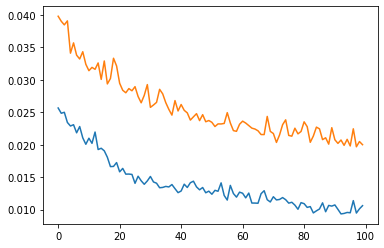

In [43]:
plt.plot(range(N_EPOCHS), ls_a) # log-cosh
plt.plot(range(N_EPOCHS), ls_b) # check


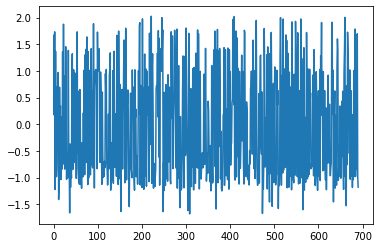

In [71]:
op_1= []
op_2= []

pltLoad= torch.utils.data.DataLoader(
                    train_data,
                    batch_size=1,
                    shuffle=True)

for inputs, labels in pltLoad:
    inputs = inputs.to(device) 
    labels = labels.to(device)
    outputs1 = model1(inputs) 
    outputs2= model2(inputs)
    op_1.append(outputs1[0][0])
    op_2.append(outputs2[0][0])

plt.plot(range(len(pltLoad)), op_1)
plt.plot(range(len(pltLoad)), op_2)